In [1]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Data sourced from: https://www.kaggle.com/datasets/namangarg2075/data-profession-salary-trends-2009-2016/code

In [2]:
salary_data = pd.read_csv('datasets/cleaned_data.csv')

In [3]:
salary_data.head(3)

,FIRST NAME,LAST NAME,SEX,DOJ,CURRENT DATE,DESIGNATION,AGE,UNIT,LEAVES USED,LEAVES REMAINING,RATINGS,PAST EXP,SALARY,DAY,DAY NAME,MONTH,YEAR
0,TOMASA,ARMEN,F,2014-05-18,2016-01-07,Analyst,21.0,Finance,24,6,2.0,0,44570,18,Sunday,5,2014
1,OLIVE,ANCY,F,2014-07-28,2016-01-07,Analyst,21.0,Finance,23,7,3.0,0,40955,28,Monday,7,2014
2,CHERRY,AQUILAR,F,2013-04-03,2016-01-07,Analyst,22.0,IT,22,8,3.0,0,45550,3,Wednesday,4,2013


In [4]:
it_salary_data = salary_data[salary_data['UNIT'] == 'IT']

In [5]:
it_salary_experienced = it_salary_data[it_salary_data['PAST EXP'] > 2]

In [6]:
it_salary_experienced = it_salary_experienced[it_salary_data['PAST EXP'] <= 5]

C:\Users\bourb\AppData\Local\Temp\ipykernel_21412\1273184617.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  it_salary_experienced = it_salary_experienced[it_salary_data['PAST EXP'] <= 5]


In [7]:
it_salary_experienced.describe()

,AGE,LEAVES USED,LEAVES REMAINING,RATINGS,PAST EXP,SALARY,DAY,MONTH,YEAR
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,27.488889,21.688889,8.311111,3.288889,3.511111,66263.000000,17.511111,6.844444,2013.533333
std,2.702038,4.389151,4.389151,1.100046,0.726831,24310.869351,8.973755,3.592641,1.035725
min,25.000000,15.000000,0.000000,2.000000,3.000000,40261.000000,2.000000,1.000000,2011.000000
25%,25.000000,18.000000,5.000000,2.000000,3.000000,47590.000000,10.000000,4.000000,2013.000000
50%,27.000000,22.000000,8.000000,3.000000,3.000000,56728.000000,17.000000,8.000000,2014.000000
75%,29.000000,25.000000,12.000000,4.000000,4.000000,85615.000000,25.000000,10.000000,2014.000000
max,33.000000,30.000000,15.000000,5.000000,5.000000,126181.000000,31.000000,12.000000,2015.000000


In [8]:
ten_percent = (it_salary_experienced['SALARY'].max() - it_salary_experienced['SALARY'].min()) / 10

In [9]:
base = float(it_salary_experienced['SALARY'].min())

salary_bins = [base]

while len(salary_bins) < 11:
    base += ten_percent
    salary_bins.append(base)

In [10]:
salary_bins

[40261.0,
 48853.0,
 57445.0,
 66037.0,
 74629.0,
 83221.0,
 91813.0,
 100405.0,
 108997.0,
 117589.0,
 126181.0]

In [11]:
it_salary_experienced['binned'] = pd.cut(it_salary_experienced['SALARY'], bins=salary_bins)

bar_data = it_salary_experienced[['binned', 'SALARY']].groupby('binned').count()

bar_data = bar_data.rename(columns = {'SALARY':'Count'})

bar_data

C:\Users\bourb\AppData\Local\Temp\ipykernel_21412\1596932444.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bar_data = it_salary_experienced[['binned', 'SALARY']].groupby('binned').count()


,Count
binned,
"(40261.0, 48853.0]",13
"(48853.0, 57445.0]",9
"(57445.0, 66037.0]",6
"(66037.0, 74629.0]",1
"(74629.0, 83221.0]",3
"(83221.0, 91813.0]",4
"(91813.0, 100405.0]",4
"(100405.0, 108997.0]",1
"(108997.0, 117589.0]",0


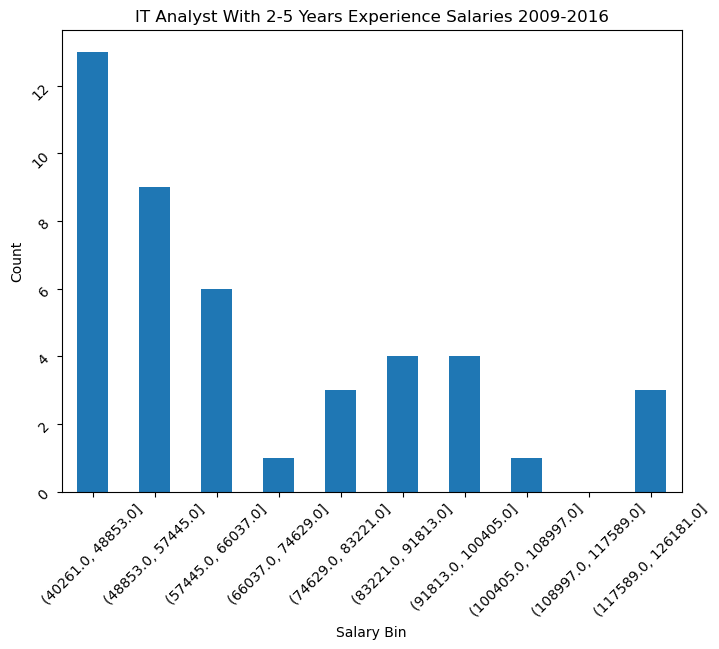

In [12]:
data = bar_data

fig, ax = plt.subplots(figsize=(8, 6))
data.plot.bar(ax=ax, legend=False)

ax.set_title('IT Analyst With 2-5 Years Experience Salaries 2009-2016')
ax.set_xlabel('Salary Bin')
ax.set_ylabel('Count')
ax.tick_params(rotation=45)

plt.show()

In [13]:
heat_data = salary_data.drop(columns=['LEAVES USED', 'LEAVES REMAINING', 'DAY', 'MONTH', 'YEAR'])

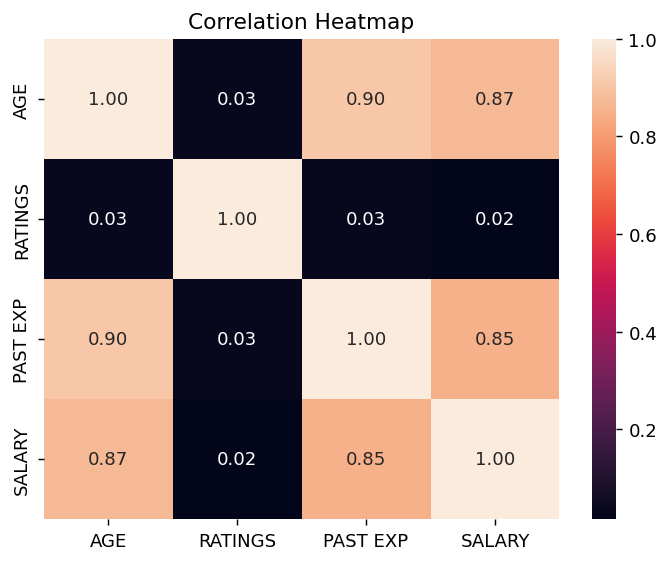

In [14]:
numerical_columns = heat_data.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation matrix for numerical columns
corr = heat_data[numerical_columns].corr()

# Plot correlation heatmap
plt.figure(dpi=130)
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [15]:
salary_data['DOJ'] = pd.to_datetime(salary_data['DOJ'])
salary_data['CURRENT DATE'] = pd.to_datetime(salary_data['CURRENT DATE'])

salary_data['TENURE'] = (salary_data['CURRENT DATE'] - salary_data['DOJ']).dt.days // 365.25
salary_data['TOTAL_EXP'] = salary_data['PAST EXP'] + salary_data['TENURE']


salary_data = salary_data.drop(columns=['DOJ', 'CURRENT DATE','FIRST NAME','LAST NAME','LEAVES REMAINING','PAST EXP','TENURE',
                                        'AGE','LEAVES USED', 'DAY', 'DAY NAME', 'MONTH', 'YEAR'])
salary_data = salary_data.dropna()
model_data = salary_data.drop_duplicates()
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2473 entries, 0 to 2476
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SEX          2473 non-null   object 
 1   DESIGNATION  2473 non-null   object 
 2   UNIT         2473 non-null   object 
 3   RATINGS      2473 non-null   float64
 4   SALARY       2473 non-null   int64  
 5   TOTAL_EXP    2473 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 135.2+ KB


In [16]:
X_train, X_test, y_train, y_test = train_test_split(model_data.drop(columns=["SALARY"]),model_data["SALARY"], test_size=0.2, random_state=42)

In [17]:
s1 = ColumnTransformer([
    ('ord', OrdinalEncoder(categories=[['Analyst', 'Associate', 'Senior Analyst', 'Manager', 'Senior Manager', 'Director']]), ['DESIGNATION']),
    ('onehot', OneHotEncoder(), ['UNIT', 'SEX'])
], remainder='passthrough')

s3 = ColumnTransformer([
    ('Scale', StandardScaler(), slice(0,122))
], remainder="passthrough")
# List of models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors Regression": KNeighborsRegressor(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "Gradient Boosting Regression": GradientBoostingRegressor()
}

# Fit and evaluate each model
for name, model in models.items():
    pipeline = Pipeline([
        ("s1", s1),
        ("s2", model),
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} R2 Score: {r2}")

Linear Regression R2 Score: 0.8318238230627176
Logistic Regression R2 Score: 0.6660777892824767
K-Nearest Neighbors Regression R2 Score: 0.8923725318770228
Decision Tree Regression R2 Score: 0.8927738852491887
Random Forest Regression R2 Score: 0.9534920638606139
Gradient Boosting Regression R2 Score: 0.9501696826696266


In [18]:
s2 = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=4
)

model = Pipeline([
    ("s1", s1),
    ("s2", s2),
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print("R2 Score:", r2)

R2 Score: 0.9574458326628773


In [19]:
input_data = pd.DataFrame({
        'NAME': ["Matt"],
        'AGE': [40],
        'SEX': ["M"],
        'DESIGNATION': ["Associate"],
        'UNIT': ["IT"],
        'PAST_EXP': [2],
        'RATINGS': [4.0],
        'DOJ': ["2024-09-01"]
    })

def preprocess_input(df):

    df['DOJ'] = pd.to_datetime(df['DOJ'])
    df['CURRENT DATE'] = pd.to_datetime('2024-08-24')

    df['TENURE'] = (df['CURRENT DATE'] - df['DOJ']).dt.days // 365.25
    df['TOTAL_EXP'] = df['PAST_EXP'] + df['TENURE']
    df = df.drop(columns=['DOJ', 'CURRENT DATE', 'NAME', 'PAST_EXP', 'TENURE', 'AGE'])
    total_experience=int(df['TOTAL_EXP'][0])
    
    return df

def predict_salary(data):
    preprocessed_data = preprocess_input(data)

    salary = model.predict(preprocessed_data)
    return salary

salary_prediction = predict_salary(input_data)
print(f'Predicted Salary: {salary_prediction[0]}')

Predicted Salary: 91731.18411774334
